# Summary

#### The data in wine-analysis is a compilation of wine data from 7 different countries that looks at wines from over 10,000 wineries accross various regions. The wine analysis data covers a period of 15 years beginning in 2001 and ending in 2016. The analysis below looks at the average wine rating by country and compares it to the average wine rating for all wineries to see how each country compares. The analysis also looks at the most popular wine varieties by country and the number of varieties found in each country. This provides an overview of how each country rates in terms of wine quality and takes a look at the wine industries diversity in each country by means of the number of varieties. Finally, the analysis looks at how the wine quality in each country trends over time and how each countries wines compare to the average over time.¶

In [1]:
#Import Modules 
import os 
import csv 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import numpy as np
import re

In [2]:
#Open Wine File 
csv_path = 'Resources/winemag-data.csv'

In [3]:
#Read wine data 
wine_data_pd = pd.read_csv(csv_path)

#Cleaning Data 
#Read wine data 
wine_data_pd = pd.read_csv(csv_path)

#Cleaning Data 
#droping wines with missing values in 'price', 'region_1','designation','points','price','title','description','variety'
clean_data_pd = wine_data_pd.drop(['taster_name', 'taster_twitter_handle'], axis=1)
clean_data_pd = clean_data_pd.dropna(subset=['price', 'region_1','designation','points','price','title','description','variety'])
clean_data_pd

# Add a wine year column
# Wine Years: Wine year was derived by searching for a 4 digit numeric value beginning with a "2".
#There are wine titles that include years prior to the year 2000. Based on additional analysis
# years prior to 2000 are not accurate with the exception of a 1947 and a 1945 year.
clean_data_pd['Wine Year'] = wine_data_pd['title'].str.extract(r'(2\d{3})(?=\s|$)')
clean_data_pd["counter"] = 1
clean_data_pd.head()

# clean_data_pd.dropna(inplace=True)
clean_data_pd.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,Wine Year,counter
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,1
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,1
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,1


### Additional Questions

In [4]:
# Calculate the total number of unique countries
number_of_countries = clean_data_pd["country"].nunique()
print(f'The total number of countries reviewed: {number_of_countries:,}')

The total number of countries reviewed: 7


In [5]:
# Calculate the total number of unique wineries
number_of_wineries = clean_data_pd["winery"].nunique()
print(f'The total number of unique wineries reviewed: {number_of_wineries:,}')

The total number of unique wineries reviewed: 10,030


In [6]:
# Calculate the average winery rating over all years
avg_winery_rating = clean_data_pd["points"].mean()
print(f'The average winery rating of reviewed wineries (Yrs 2001 - 2016): {avg_winery_rating:.2f}')

The average winery rating of reviewed wineries (Yrs 2001 - 2016): 88.81


In [7]:
# How many varieties of wine does each country produce
variety_df = clean_data_pd[["country", "variety", "counter"]]
variety = variety_df.groupby('country')
variety_by_country_df = variety['variety'].count()
variety_by_country_df.sort_values(ascending=False, inplace=True)
variety_by_country_df.to_frame()

,variety
country,
US,36558
Italy,11973
France,11782
Spain,5249
Argentina,2821
Australia,1616
Canada,176


Text(0, 0.5, 'Number of Varieties')

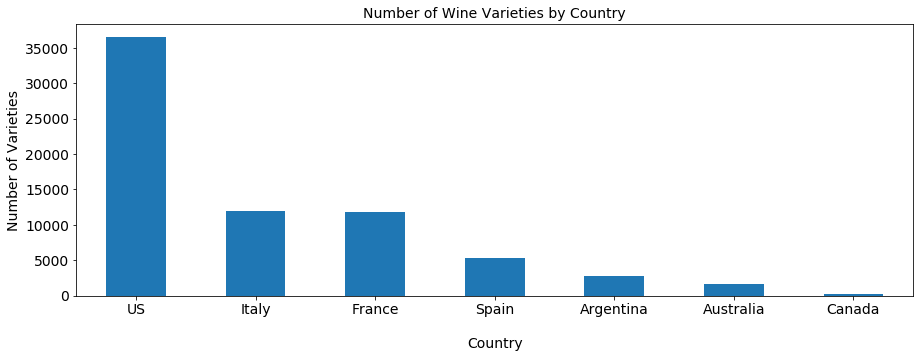

In [8]:
variety_by_country_df.plot(kind="bar",figsize=(15,5), fontsize=14, rot=0)
plt.title("Number of Wine Varieties by Country", fontsize=14)
plt.xlabel("\nCountry", fontsize=14)
plt.ylabel("Number of Varieties", fontsize=14)

## Most Popular Wine Varieties by Country

In [9]:
# Create a dataframe with a count of varieties by country
pop_variety_df = clean_data_pd[["country", "variety", "counter"]]
variety_df = pop_variety_df.groupby(['country', 'variety'], as_index=False)
country_variety_df = variety_df['counter'].sum()
country_variety_df.set_index('country', inplace=True)
country_variety_df.sort_values(by="country", ascending=False, inplace=True)
country_variety_df.reset_index(inplace=True)

In [10]:
# Create a blank dataframe used to store the most popular varieties by country
popular_variety_by_country_df = pd.DataFrame(columns=['country', 'variety', 'counter'])

j=0
country = ''
variety = ''
counter = 0

# Loop through existing variety by country df and extract the most 
# popular wine variety by country. Write that value to a new df
for i in range(len(country_variety_df)-1):
    
    k = i+1    
      
    if country_variety_df.loc[k,'country'] == country_variety_df.loc[i,'country']:
        if country_variety_df.loc[i,'counter'] > counter:
            country = country_variety_df.loc[i,'country']
            counter = country_variety_df.loc[i,'counter']
            variety = country_variety_df.loc[i,'variety']

    if country_variety_df.loc[k,'country'] != country_variety_df.loc[i,'country']:
        j+=1
        counter = 0
        
    popular_variety_by_country_df.loc[j, 'country'] = country
    popular_variety_by_country_df.loc[j, 'variety'] = variety
    popular_variety_by_country_df.loc[j, 'counter'] = counter

# show new df that includes most popular wine variety by country
popular_variety_by_country_df

,country,variety,counter
0,US,Pinot Noir,7505
1,Spain,Tempranillo,1215
2,Italy,Red Blend,2404
3,France,Chardonnay,1598
4,Canada,Riesling,43
5,Australia,Shiraz,458
6,Argentina,Malbec,1133


### Wine Rating per Country vs. Overall Wine Rating (2001-2016)

In [11]:
# Calculate the average winery rating by country for all years
country = clean_data_pd.groupby('country')
avg_country_rating_df = country['points'].mean()

# Create 2 new columns and populate with the avg wine rating and the avg classification
avg_country_rating_df=avg_country_rating_df.to_frame()
avg_country_rating_df['avg_rating'] = avg_winery_rating
avg_country_rating_df['wine_rating'] = ""

def calc_wine_rating(row):
    if row['points'] < row['avg_rating']:
        return "Below Average Wine"
    elif row['points'] == row['avg_rating']:
        return "Average Wine"
    else:
        return "Above Average Wine"     

avg_country_rating_df["wine_rating"] = avg_country_rating_df.apply(calc_wine_rating, axis=1)
avg_country_rating_df.sort_values(by='points', ascending = False, inplace = True)

avg_country_rating_df.rename(columns={'points':'Country Rating', 'avg_rating':'Overall Rating', \
                                      'wine_rating':"Wine Rating"}, inplace=True)
avg_country_rating_df

,Country Rating,Overall Rating,Wine Rating
country,,,
Canada,89.363636,88.806341,Above Average Wine
France,89.077831,88.806341,Above Average Wine
US,89.017671,88.806341,Above Average Wine
Australia,89.003713,88.806341,Above Average Wine
Italy,88.839055,88.806341,Above Average Wine
Spain,87.465994,88.806341,Below Average Wine
Argentina,87.141085,88.806341,Below Average Wine


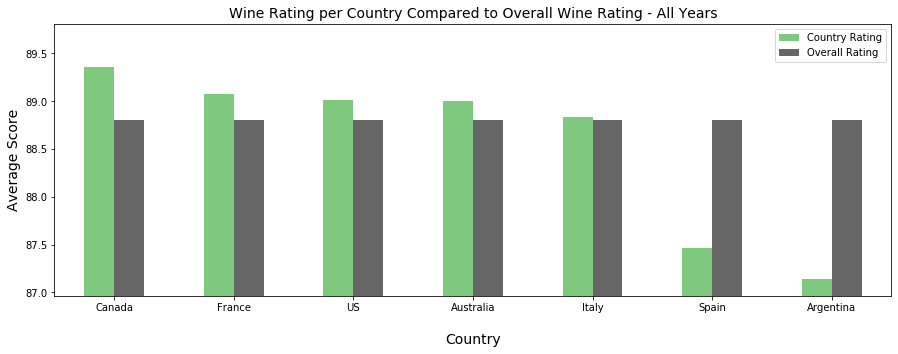

In [12]:
#Set upper and lower y-limits based on data set
lower_lim = avg_country_rating_df['Country Rating'].min() - (avg_country_rating_df['Country Rating'].min() * .002)
upper_lim = avg_country_rating_df['Country Rating'].max() + (avg_country_rating_df['Country Rating'].max() * .005)
# colormap = {avg_country_rating_df['points']:'blue', avg_country_rating_df['avg_rating']:'yellow'}


avg_country_rating_df.plot(kind="bar", figsize=(15,5), use_index=True, ylim=(lower_lim, upper_lim), colormap='Accent', rot=0)
plt.title("Wine Rating per Country Compared to Overall Wine Rating - All Years", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xlabel("\nCountry", fontsize=14)
plt.legend(loc='best')

### Calculate the Average Wine Rating by Country by Year

In [13]:
# Calculate the average wine rating by country for each year
country_year = clean_data_pd.groupby(['country', 'Wine Year'], as_index=False)
overall = clean_data_pd.groupby('Wine Year', as_index = False)
avg_country_year_rating_df = country_year['points'].mean()

# Calculate the average wine rating overall by year
avg_wine_rating_overall_df = overall['points'].mean()

# Create new columns for avg rating for all wines per year and overall wine rating
# avg_country_year_rating_df['avg_rating'] = ""
avg_country_year_rating_df['wine_rating'] = ""

# merge avg rating into the country wine rating df
avg_country_year_rating_df=avg_country_year_rating_df.merge(avg_wine_rating_overall_df, \
                                                            how="left", on="Wine Year", suffixes=('_country', '_overall'))

def calc_wine_year_rating(row):
    if row['points_country'] < row['points_overall']:
        return "Below Average Wine"
    elif row['points_country'] == row['points_overall']:
        return "Average Wine"
    else:
        return "Above Average Wine" 
    
avg_country_year_rating_df["wine_rating"] = avg_country_year_rating_df.apply(calc_wine_year_rating, axis=1)

avg_country_year_rating_df=avg_country_year_rating_df[avg_country_year_rating_df["Wine Year"] != '2017']
avg_country_year_rating_df.head()

,country,Wine Year,points_country,wine_rating,points_overall
0,Argentina,2000,83.000000,Below Average Wine,87.919881
1,Argentina,2001,82.000000,Below Average Wine,88.451827
2,Argentina,2002,88.000000,Below Average Wine,88.442105
3,Argentina,2003,86.875000,Below Average Wine,88.582090
4,Argentina,2004,88.214286,Below Average Wine,89.083102


In [14]:
# Remove Wine Year 2017 as there is only one country with 2017 data
avg_wine_rating_overall_df
avg_wine_rating_overall_df=avg_wine_rating_overall_df[avg_wine_rating_overall_df["Wine Year"] != '2017']

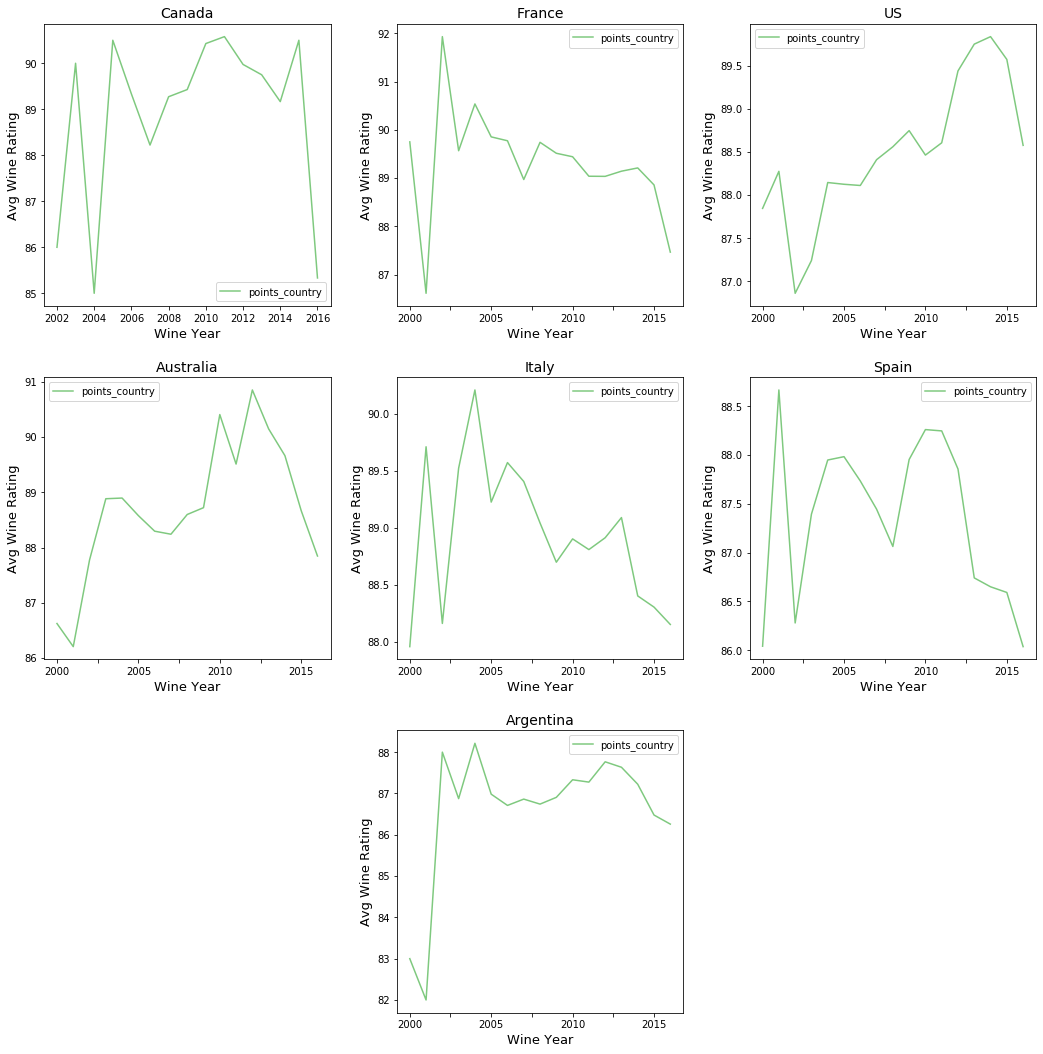

In [16]:
# Set country as the index
# avg_country_year_rating_df.set_index('country', inplace=True)

## Get US wine rating by year
ca_wine_ratings_df = avg_country_year_rating_df.loc["Canada"]
fr_wine_ratings_df = avg_country_year_rating_df.loc["France"]
us_wine_ratings_df = avg_country_year_rating_df.loc["US"]
au_wine_ratings_df = avg_country_year_rating_df.loc["Australia"]
it_wine_ratings_df = avg_country_year_rating_df.loc["Italy"]
sp_wine_ratings_df = avg_country_year_rating_df.loc["Spain"]
ag_wine_ratings_df = avg_country_year_rating_df.loc["Argentina"]

us_wine_ratings_df

# Create subplots for each country to show rating by year
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
ca_wine_ratings_df.plot(ax=axes[0,0], x="Wine Year", y='points_country', colormap='Accent')
fr_wine_ratings_df.plot(ax=axes[0,1], x="Wine Year", y='points_country', colormap='Accent')
us_wine_ratings_df.plot(ax=axes[0,2], x="Wine Year", y='points_country', colormap='Accent')
au_wine_ratings_df.plot(ax=axes[1,0], x="Wine Year", y='points_country', colormap='Accent')
it_wine_ratings_df.plot(ax=axes[1,1], x="Wine Year", y='points_country', colormap='Accent')
sp_wine_ratings_df.plot(ax=axes[1,2], x="Wine Year", y='points_country', colormap='Accent')
ag_wine_ratings_df.plot(ax=axes[2,1], x="Wine Year", y='points_country', colormap='Accent')

# # Add xlabel for each graph
for x in range(3):
    for y in range(3):
        axes[x,y].set_xlabel("Wine Year", fontsize=13)
        axes[x,y].set_ylabel("Avg Wine Rating", fontsize=13)

# # Add titles for each graph
axes[0,0].set_title("Canada", fontsize=14)
axes[0,1].set_title("France", fontsize=14)
axes[0,2].set_title("US", fontsize=14)
axes[1,0].set_title("Australia", fontsize=14)
axes[1,1].set_title("Italy", fontsize=14)
axes[1,2].set_title("Spain", fontsize=14)
axes[2,1].set_title("Argentina", fontsize=14)

fig.tight_layout(pad=2.0)

fig.delaxes(axes[2][0])
fig.delaxes(axes[2][2])